In [3]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import random as python_random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)



#### Questions:
# How does tf (under this method) store labels? Can I access them?
#    Look into how the resizing line is done
# What happens if I don't pass the y value into imageDataGenerator().flow()?
# is this enough work? (oversampling, data augmentation, adusting the prediction wieghts)
# multiple expert -  3 different model (majority voting at the end to make predictions) - cost trade off for computing
# - talk about costs (training time, different work, etc)
# - accuracy vs tradeoffs (latency of making one prediction)

In [2]:
!ls ../HOLD_data/

Covid_img  Normal_img  Viral_img


To Do:

Oversampling/Data Augmentation:

1. start a new file with clear labels, resampling, augmented data
2. Train the model the same way
3. Save model and create confusion matrix in this file (or seperate file)

Prediction weights
1. When predicting classes, change wieghts until we get 100% for covid cases
2. Change to proportional CM instead of just numeric?

Recall and F-score as metric?

In [3]:
HOLD_dir = '../HOLD_data/'
class_names = os.listdir(HOLD_dir)

batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 244; 
img_width = 244;

# Training Dataset
HOLD_ds = tf.keras.preprocessing.image_dataset_from_directory(
    HOLD_dir,
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

Found 1514 files belonging to 3 classes.


2022-04-22 00:58:30.785173: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-22 00:58:30.785211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udc-ba27-18): /proc/driver/nvidia/version does not exist
2022-04-22 00:58:30.788328: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model 1: Resnet

In [12]:
# load model
saved_model_1 = tf.keras.models.load_model('./saved_models/rn_model')
predictions_1 = saved_model_1.predict(HOLD_ds, batch_size=batch_size)

In [13]:
saved_model_1

In [14]:
predictions_1

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [15]:
np.sum(predictions_1, axis=0)

array([1514.,    0.,    0.], dtype=float32)

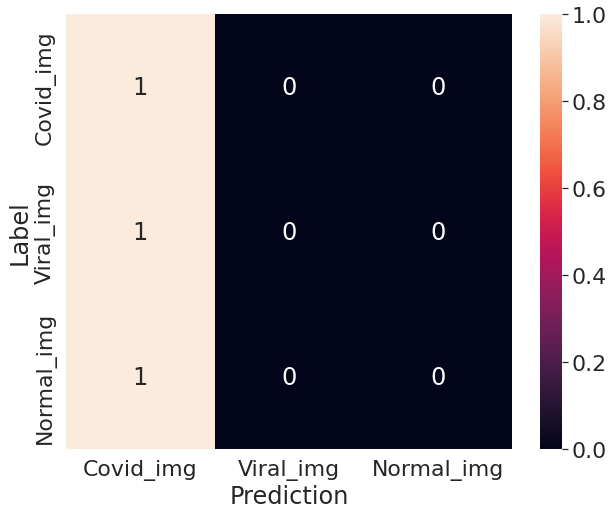

In [20]:
y_true = []
for img, label in HOLD_ds:
    y_true.append(label.numpy())
y_true

# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    np.argmax(predictions_1, axis=1),
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix1.png')
plt.show()

# Model 2: ??????

In [17]:
# load model
saved_model_2 = tf.keras.models.load_model('./saved_models/model_1')
predictions_2 = saved_model_2.predict(HOLD_ds)

In [18]:
predictions_2

array([[1.6920679e-07, 1.3094642e-07, 9.9999964e-01],
       [1.2278818e-09, 9.9999952e-01, 4.7643121e-07],
       [3.5860288e-09, 1.0000000e+00, 4.7863831e-11],
       ...,
       [7.0730562e-07, 9.9999928e-01, 1.6203670e-10],
       [1.0000000e+00, 1.2856473e-12, 2.2554239e-10],
       [9.9999690e-01, 3.0942595e-06, 1.9970477e-08]], dtype=float32)

In [27]:
# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    np.argmax(predictions_2, axis=1),
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix2.png')
plt.show()

ValueError: Shapes (1514,) and (3,) are incompatible

In [ ]:
for img, label in HOLD_ds:
    print(label)

# Combine the predictions

In [25]:
max_pred = predictions_1 + predictions_2 #+ predictions_3
max_pred

array([[1.0000001e+00, 1.3094642e-07, 9.9999964e-01],
       [1.0000000e+00, 9.9999952e-01, 4.7643121e-07],
       [1.0000000e+00, 1.0000000e+00, 4.7863831e-11],
       ...,
       [1.0000007e+00, 9.9999928e-01, 1.6203670e-10],
       [2.0000000e+00, 1.2856473e-12, 2.2554239e-10],
       [1.9999969e+00, 3.0942595e-06, 1.9970477e-08]], dtype=float32)

In [ ]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
# threshold = .2 # threshold should be determined on test data not holdout (maybe do this above but on holdout data?)

np.apply_along_axis(lambda x: x[1])

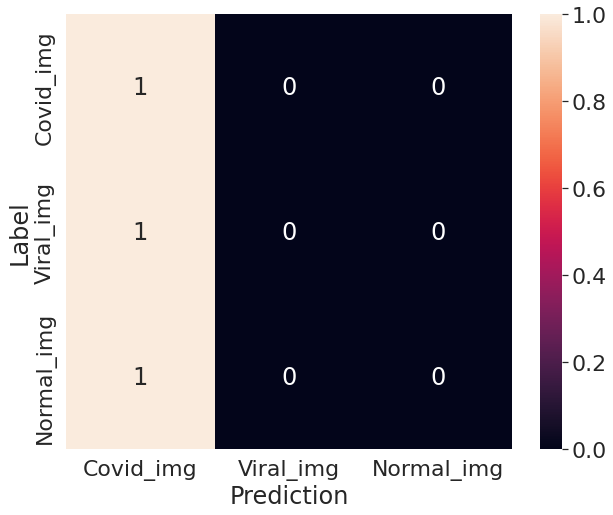

In [24]:
# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    np.argmax(max_pred, axis=1),
    num_classes=3,
    weights=None) # change to get to 100% covid accuracy
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix2.png')
plt.show()

In [9]:
arr = [[.4,.5,1],[.4,.5,1],[.4,.5,1],[.4,.5,1],[.4,.5,1]]
np.apply_along_axis((lambda x: [1,x[1],x[2]] if x[0]>.2),1,arr)

SyntaxError: invalid syntax (4006812997.py, line 2)